# Part 3 Task 1
https://github.com/josStorer/RWKV-Runner/blob/master/README_ZH.md

# 正式开始构建这个Pipeline

## Clone Git

In [1]:
!git clone https://github.com/josStorer/RWKV-Runner.git

Cloning into 'RWKV-Runner'...
remote: Enumerating objects: 8117, done.
remote: Counting objects: 100% (2339/2339), done.
remote: Compressing objects: 100% (666/666), done.
remote: Total 8117 (delta 1812), reused 1677 (delta 1673), pack-reused 5778 (from 2)
Receiving objects: 100% (8117/8117), 82.49 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (5635/5635), done.


In [8]:
# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 初始化环境

In [2]:
# 重设python环境（请选择1）
!update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!update-alternatives --config python3

There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.12   2         auto mode
  1            /usr/bin/python3.10   1         manual mode
  2            /usr/bin/python3.12   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1
update-alternatives: using /usr/bin/python3.10 to provide /usr/bin/python3 (python3) in manual mode


In [3]:
# 重新安装pip
!curl -sS https://bootstrap.pypa.io/get-pip.py | python3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pip]


In [4]:
!/usr/bin/python3.10 -m pip install -r RWKV-Runner/backend-python/requirements.txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 39.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 161.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 101.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 94.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 100.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 196.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!/usr/bin/python3.10 -m pip install ninja

In [6]:
!pip install -q huggingface_hub

In [7]:
!pip install -q datasets

## 设置路径

In [9]:
import os
# TODO: Set Your Own Dir toward the "DSGA1011 NLP Final Project"
base_dir = os.path.join('/content/drive', 'MyDrive', 'DSGA1011 NLP Final Project')
base_dir

'/content/drive/MyDrive/DSGA1011 NLP Final Project'

In [10]:
os.path.exists(base_dir)

True

In [11]:
# the working dir
working_dir = os.path.join(base_dir, 'RWKV Dataset Test')

# Check whether the file exist, if not, raise error
if not os.path.exists(working_dir):
  raise Exception('The working dir does not exist')
else:
  # Print the file under it
  sub_files = os.listdir(working_dir)
  # add /n to subfiles
  sub_files = "\n".join(sub_files)
  file_info = f"The existing files under {working_dir} are: \n{sub_files}"
  print(file_info)

The existing files under /content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV Dataset Test are: 
Tryrunner_for_RACE.ipynb


## 模型下载

In [12]:
import os
import shutil
from huggingface_hub import hf_hub_download

# ===========================================================
# 1. 统一配置：模型展示名称 → { filename, repo_id }
#    统一下载到 /content/models
# ===========================================================

MODEL_BASE_DIR = "/content/models"

MODEL_SOURCES = {
    # --- World series ---
    "World 0.1B": {
        "filename": "RWKV-x070-World-0.1B-v2.8-20241210-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-world",
    },
    "World 0.4B": {
        "filename": "RWKV-x070-World-0.4B-v2.9-20250107-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-world",
    },
    "World 1.5B": {
        "filename": "RWKV-x070-World-1.5B-v3-20250127-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-world",
    },
    "World 2.9B": {
        "filename": "RWKV-x070-World-2.9B-v3-20250211-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-world",
    },

    # --- Pile series ---
    "Pile 1.47B": {
        "filename": "RWKV-x070-Pile-1.47B-20241210-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-pile",
    },
    "Pile 421M": {
        "filename": "RWKV-x070-Pile-421M-20241127-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-pile",
    },
    "Pile 168M": {
        "filename": "RWKV-x070-Pile-168M-20241120-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-pile",
    },
    "Pile 165M L25-D576": {
        "filename": "RWKV-x070-Pile-165M-L25-D576-20241218-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-pile",
    },
    "Pile 164M L33-D512": {
        "filename": "RWKV-x070-Pile-164M-L33-D512-20241218-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-pile",
    },

    # --- g1 series（注意 repo_id 和 2.9B 的日期） ---
    "g1 0.1B": {
        "filename": "rwkv7-g1-0.1b-20250307-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv7-g1",
    },
    "g1 0.4B": {
        "filename": "rwkv7-g1-0.4b-20250324-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv7-g1",
    },
    "g1 1.5B": {
        "filename": "rwkv7-g1-1.5b-20250429-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv7-g1",
    },
    "g1 2.9B": {
        "filename": "rwkv7-g1-2.9b-20250519-ctx4096.pth",  # ← 这里用 19
        "repo_id": "BlinkDL/rwkv7-g1",
    },
}


# ===========================================================
# 2. 用 hf_hub_download 下载单个模型
# ===========================================================

def download_model(repo_id: str, filename: str, local_path: str) -> bool:
    """
    Download a model file via hf_hub_download, then copy
    from HF 缓存到 local_path（/content/models/...）。

    Return True if success, False otherwise.
    """
    try:
        os.makedirs(os.path.dirname(local_path), exist_ok=True)

        print(f"[INFO] Downloading {filename} from {repo_id} via hf_hub_download ...")
        # 这一步会：
        # - 处理权限 / token
        # - 自动断点续传
        # - 用自己的 tqdm 显示下载进度
        downloaded_path = hf_hub_download(
            repo_id=repo_id,
            filename=filename,
            repo_type="model",
        )

        # 如果缓存路径和目标路径不同，就拷贝一份
        if downloaded_path != local_path:
            shutil.copy2(downloaded_path, local_path)

        print(f"[OK] Saved to {local_path}\n")
        return True

    except Exception as e:
        print(f"[ERROR] Failed to download {filename} from {repo_id}: {e}\n")
        # 出错时尽量删掉半截文件
        try:
            if os.path.exists(local_path):
                os.remove(local_path)
        except Exception:
            pass
        return False


# ===========================================================
# 3. 主入口：根据 selected_models 构建最终 model_dict
# ===========================================================

def prepare_model_dict(selected_models, base_dir: str = MODEL_BASE_DIR):
    """
    Build a model_dict for selected models using hf_hub_download.

    规则：
    1. 只处理 selected_models 里指定的模型；
    2. 如果 /content/models 下已有对应文件，直接复用；
    3. 如果本地没有，就用 hf_hub_download 下载；
    4. 下载失败则跳过，并且不写入字典。
    """
    os.makedirs(base_dir, exist_ok=True)
    model_dict = {}

    for name in selected_models:
        if name not in MODEL_SOURCES:
            print(f"[WARN] Unknown model name: {name}, skipped.")
            continue

        info = MODEL_SOURCES[name]
        filename = info["filename"]
        repo_id = info["repo_id"]
        local_path = os.path.join(base_dir, filename)

        # 1) 已经下载过？
        if os.path.exists(local_path):
            print(f"[OK] Found local model: {name} -> {local_path}")
            model_dict[name] = local_path
            continue

        # 2) 没有就下载
        ok = download_model(repo_id, filename, local_path)

        # 3) 下载成功才写入字典
        if ok and os.path.exists(local_path):
            model_dict[name] = local_path
        else:
            print(f"[ERROR] {name} download failed, not added to model_dict.\n")

    return model_dict

In [13]:
# # ===== 只选 World和g1 系列 =====

selected_models = [
    name for name in MODEL_SOURCES.keys()
    if name.startswith("World ") or name.startswith("g1 ")
]

model_dict = prepare_model_dict(selected_models)

print("Final model_dict:", model_dict)

[INFO] Downloading RWKV-x070-World-0.1B-v2.8-20241210-ctx4096.pth from BlinkDL/rwkv-7-world via hf_hub_download ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RWKV-x070-World-0.1B-v2.8-20241210-ctx40(…):   0%|          | 0.00/382M [00:00<?, ?B/s]

[OK] Saved to /content/models/RWKV-x070-World-0.1B-v2.8-20241210-ctx4096.pth

[INFO] Downloading RWKV-x070-World-0.4B-v2.9-20250107-ctx4096.pth from BlinkDL/rwkv-7-world via hf_hub_download ...


RWKV-x070-World-0.4B-v2.9-20250107-ctx40(…):   0%|          | 0.00/902M [00:00<?, ?B/s]

[OK] Saved to /content/models/RWKV-x070-World-0.4B-v2.9-20250107-ctx4096.pth

[INFO] Downloading RWKV-x070-World-1.5B-v3-20250127-ctx4096.pth from BlinkDL/rwkv-7-world via hf_hub_download ...


RWKV-x070-World-1.5B-v3-20250127-ctx4096(…):   0%|          | 0.00/3.06G [00:00<?, ?B/s]

[OK] Saved to /content/models/RWKV-x070-World-1.5B-v3-20250127-ctx4096.pth

[INFO] Downloading RWKV-x070-World-2.9B-v3-20250211-ctx4096.pth from BlinkDL/rwkv-7-world via hf_hub_download ...


RWKV-x070-World-2.9B-v3-20250211-ctx4096(…):   0%|          | 0.00/5.90G [00:00<?, ?B/s]

[OK] Saved to /content/models/RWKV-x070-World-2.9B-v3-20250211-ctx4096.pth

[INFO] Downloading rwkv7-g1-0.1b-20250307-ctx4096.pth from BlinkDL/rwkv7-g1 via hf_hub_download ...


rwkv7-g1-0.1b-20250307-ctx4096.pth:   0%|          | 0.00/382M [00:00<?, ?B/s]

[OK] Saved to /content/models/rwkv7-g1-0.1b-20250307-ctx4096.pth

[INFO] Downloading rwkv7-g1-0.4b-20250324-ctx4096.pth from BlinkDL/rwkv7-g1 via hf_hub_download ...


rwkv7-g1-0.4b-20250324-ctx4096.pth:   0%|          | 0.00/902M [00:00<?, ?B/s]

[OK] Saved to /content/models/rwkv7-g1-0.4b-20250324-ctx4096.pth

[INFO] Downloading rwkv7-g1-1.5b-20250429-ctx4096.pth from BlinkDL/rwkv7-g1 via hf_hub_download ...


rwkv7-g1-1.5b-20250429-ctx4096.pth:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

[OK] Saved to /content/models/rwkv7-g1-1.5b-20250429-ctx4096.pth

[INFO] Downloading rwkv7-g1-2.9b-20250519-ctx4096.pth from BlinkDL/rwkv7-g1 via hf_hub_download ...


rwkv7-g1-2.9b-20250519-ctx4096.pth:   0%|          | 0.00/5.90G [00:00<?, ?B/s]

[OK] Saved to /content/models/rwkv7-g1-2.9b-20250519-ctx4096.pth

Final model_dict: {'World 0.1B': '/content/models/RWKV-x070-World-0.1B-v2.8-20241210-ctx4096.pth', 'World 0.4B': '/content/models/RWKV-x070-World-0.4B-v2.9-20250107-ctx4096.pth', 'World 1.5B': '/content/models/RWKV-x070-World-1.5B-v3-20250127-ctx4096.pth', 'World 2.9B': '/content/models/RWKV-x070-World-2.9B-v3-20250211-ctx4096.pth', 'g1 0.1B': '/content/models/rwkv7-g1-0.1b-20250307-ctx4096.pth', 'g1 0.4B': '/content/models/rwkv7-g1-0.4b-20250324-ctx4096.pth', 'g1 1.5B': '/content/models/rwkv7-g1-1.5b-20250429-ctx4096.pth', 'g1 2.9B': '/content/models/rwkv7-g1-2.9b-20250519-ctx4096.pth'}


## 启动服务器

In [34]:
# Star url
!fuser -k 8000/tcp || true
!/usr/bin/python3.10 RWKV-Runner/backend-python/main.py --host 0.0.0.0 --port 8000 > server.log 2>&1 &
# !/usr/bin/python3.10 RWKV-Runner/backend-python/main.py --host 0.0.0.0 --port 8000 2>&1 | tee server.log

In [30]:
# API doc
from google.colab import output
docs_url = output.eval_js("google.colab.kernel.proxyPort(8000)") + "/docs"
print("Docs URL:", docs_url)


Docs URL: https://8000-gpu-t4-hm-2roapxde547nt-a.asia-southeast1-0.prod.colab.dev/docs


In [16]:
# # Enable cache
import requests
!/usr/bin/python3.10 -m pip install cyac==1.9
cache_enable_resp = requests.post("http://127.0.0.1:8000/enable-state-cache")
print(cache_enable_resp.status_code, cache_enable_resp.text)
# 200 "success"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cyac: filename=cyac-1.9-cp310-cp310-linux_x86_64.whl size=1038258 sha256=03a0272e52e8d2e8da59ae115b56210033baec0b0a04f90a2c08adb60e8f58aa
  Stored in directory: /root/.cache/pip/wheels/40/ae/45/9076427b28cf92fb626c2246994afd3aacec5e0c0ce060de1a
Successfully built cyac
200 "success"


In [17]:
# Import
import requests
import json
import time
import re
from tqdm.auto import tqdm

## Basic Functions for model

In [42]:
def bulid_chat_body(
  content_list: list,
  model="rwkv",
  max_tokens=128,
  temperature=0.3
    ):

  chat_body = {
    "model": model,
    "messages": [
      {
        "role": "user",
        "content":"\n\n".join(content_list),
        "raw": False
      }
    ],
    "stream": False,
    "max_tokens": max_tokens,
    "temperature": temperature
  }
  return chat_body

def parse_choice_letter(text: str):
  """
  Parse the model output and return one of {'A','B','C','D'} if found,
  otherwise return None.

  策略：
  1. 按行拆分，找每一行第一个非空字符是不是 A/B/C/D。
  2. 如果没有，再在整段文本里用正则找独立出现的 A/B/C/D。
  """
  if not text:
      return None

  # 1) 逐行检查：第一非空字符如果是 A/B/C/D 就直接用它
  lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
  for ln in lines:
      # 例如 "A", "A: 10 hours", "B) xxx"
      m = re.match(r'^([ABCD])\b', ln, flags=re.IGNORECASE)
      if m:
          return m.group(1).upper()

  # 2) 全文里找独立出现的 A/B/C/D（比如 "answer is B."）
  m = re.search(r'\b([ABCD])\b', text, flags=re.IGNORECASE)
  if m:
      return m.group(1).upper()

  return None

# def get_response(chat_body, chat_mode = "chat/completions"):
#   r = requests.post(f"http://127.0.0.1:8000/{chat_mode}", json=chat_body)
#   return r.json()["choices"][0]["message"]["content"]

def switch_model(version="World 0.1B"):
  model_path = model_dict[version]

  swich_body = {
    "model": model_path,
    "strategy": "cuda fp16",
    "tokenizer": "",
    "customCuda": True,
    "deploy": False
  }

  r = requests.post("http://127.0.0.1:8000/switch-model", json=swich_body)
  if r.status_code != 200:
    print(f"[switch_model] Warning: failed to switch model: {r.text}")
  else:
    print(f"Success: switched to {version}")
    # print(json.dumps(r.json(), indent=2))
  # 200 "success"

# RACE Dataset


## 加载和分析RACE数据集

In [19]:
from datasets import load_dataset

# 所有数据
race_all = load_dataset("ehovy/race", "all")

README.md: 0.00B [00:00, ?B/s]

all/test-00000-of-00001.parquet:   0%|          | 0.00/2.08M [00:00<?, ?B/s]

all/train-00000-of-00001.parquet:   0%|          | 0.00/37.4M [00:00<?, ?B/s]

all/validation-00000-of-00001.parquet:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4934 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/87866 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4887 [00:00<?, ? examples/s]

In [20]:
print(f"example_number_of_all_validation: {len(race_all['validation'])}")
print(f"keys of race data sample:{race_all["train"][0].keys()}")
print(f"Answer example: {race_all["train"][0]['answer']}")


example_number_of_all_validation: 4887
keys of race data sample:dict_keys(['example_id', 'article', 'answer', 'question', 'options'])
Answer example: C


In [21]:
article_text = race_all["train"][0]['article']
words = article_text.split()
word_count = len(words)
print(f"The article has {word_count} words.")

The article has 327 words.


## Race数据集辅助函数

In [22]:
# 测试是否我们总是能从'example_id'获得middle或者high

def get_difficulty(samp):
  example_id = samp["example_id"]
  is_high = False
  is_middle = False
  if "high" in example_id:
    is_high = True
  if "middle" in example_id:
    is_middle = True

  if is_high and is_middle:
    raise ValueError(f"example_id {example_id} is both high and middle")
  elif (not is_high) and (not is_middle):
    raise ValueError(f"example_id {example_id} is neither high nor middle")
  elif is_high:
    return "high"
  elif is_middle:
    return "middle"
  else:
    raise ValueError("Something went wrong with the process of '[get_difficulty]'")

# for split in ["train", "validation", "test"]:
#   for samp in tqdm(race_all[split]):
#     if get_difficulty(samp) in ["high", "middle"]:
#       pass
#     else:
#       raise ValueError(f"Unkown difficulty {get_difficulty(samp)}")


## RACE数据辅助函数

In [23]:
def get_question_str(samp):
  question = samp["question"]
  opts = samp["options"]
  return "\n".join([
      "Question:",
      question,
      "\nOptions:",
      f"A: {opts[0]}",
      f"B: {opts[1]}",
      f"C: {opts[2]}",
      f"D: {opts[3]}",
  ])

## 单个问题测试（跑通了再走下一步）

In [43]:
import json
import requests

# 1) 选模型
test_model = list(model_dict.keys())[0]  # 或者你想测的那个
print("Using model:", test_model)
switch_model(test_model)

# 2) 角色设定 + 规则
charater_setting = (
    "You are a careful reasoner. "
    "You will read one long passage and answer a multiple-choice question about it.\n"
)

rule_setting = (
    "There are exactly four options: A, B, C, and D.\n"
    "When you answer, you MUST output ONLY one letter from {A,B,C,D}.\n"
    "Output ONLY the letter on the first line, with nothing else.\n"
)

# 3) 准备一个“完全无关的示例 QA”（来自 RACE train 的第一条）
example_samp = race_all["train"][0]           # 示例题
example_q_str = get_question_str(example_samp)
example_gold = example_samp["answer"]         # 'A'/'B'/'C'/'D'

# 4) 准备当前要预测的样本（RACE 里的任意一条）
test_samp = race_all["validation"][0]         # 你也可以用 train[4] 等
article = test_samp["article"]
q_str = get_question_str(test_samp)
gold_answer = test_samp["answer"]

print("GOLD:", gold_answer)

# 5) 构造 prompt：
#    - 先给规则
#    - 给当前 passage
#    - 再给“无关例题 + 正确答案 + 正确输出示范”
#    - 最后给当前问题，并用 Answer (A/B/C/D only): 结尾
prompt = (
    f"{charater_setting}"
    f"{rule_setting}\n"
    "IMPORTANT: In all cases, DO NOT write explanations, DO NOT write extra words.\n"
    "Your final answer must be ONLY one of the letters: A, B, C, or D.\n\n"
    # 当前文章
    f"Passage:\n{article}\n\n"
    # 无关示例 QA：只展示格式
    "Now look at an example question that is NOT about the passage above.\n"
    "It is ONLY to show you the answer format. DO NOT answer it again.\n\n"
    f"{example_q_str}\n\n"
    f"In this example, the correct choice is {example_gold}.\n"
    "So your output for this example (if you were answering) should be:\n"
    f"{example_gold}\n\n"
    # 真正要回答的问题
    "Now you will answer a question about THE PASSAGE at the top.\n"
    "REMEMBER:\n"
    "- Do NOT repeat the question.\n"
    "- Do NOT write explanations.\n"
    "- Output ONLY one letter from {A,B,C,D} on the first line.\n\n"
    f"{q_str}\n\n"
    "Answer (A/B/C/D only):"
)

print("\n=== Prompt preview (truncated) ===")
print(prompt[:800], "...\n")

# 6) 构造请求体并发送
content_list = [prompt]  # 整个 prompt 作为一个 message
chat_body = bulid_chat_body(
    content_list,
    max_tokens=32,       # 放宽一点，配合宽松版 parse_choice_letter
    temperature=0.0,
)

resp = requests.post(
    "http://127.0.0.1:8000/chat/completions",
    json=chat_body,
    timeout=60,
)

print("HTTP status:", resp.status_code)

if resp.status_code != 200:
    print("Response text:", resp.text)
else:
    resp_json = resp.json()
    print("\n=== Raw JSON response (truncated) ===")
    print(json.dumps(resp_json, indent=2, ensure_ascii=False)[:800], "...\n")

    raw_text = resp_json["choices"][0]["message"]["content"]
    print("=== raw content (repr) ===")
    print(repr(raw_text))

    # 这里用的是你已经改成“宽松”的 parse_choice_letter
    pred_choice = parse_choice_letter(raw_text)
    print("\nPRED:", pred_choice, "GOLD:", gold_answer)


Using model: World 0.1B
Success: switched to World 0.1B
GOLD: C

=== Prompt preview (truncated) ===
You are a careful reasoner. You will read one long passage and answer a multiple-choice question about it.
There are exactly four options: A, B, C, and D.
When you answer, you MUST output ONLY one letter from {A,B,C,D}.
Output ONLY the letter on the first line, with nothing else.

IMPORTANT: In all cases, DO NOT write explanations, DO NOT write extra words.
Your final answer must be ONLY one of the letters: A, B, C, or D.

Passage:
I am a psychologist. I first met Timothy, a quiet, overweight eleven-year-old boy, when his mother brought him to me to discuss his declining grades. A few minutes with Timothy were enough to confirm that his self-esteem  and general happiness were falling right along with _ . I asked about Timothy's typical day. He awoke every morning at six thirty so he could  ...

HTTP status: 200

=== Raw JSON response (truncated) ===
{
  "object": "chat.completion",
  "mo

## 遍历所有内容（上一步跑通了再这一步）

In [45]:
import os
import json
import time
import gc
import requests
from tqdm.auto import tqdm

# optional: monitor current Python process memory
try:
    import psutil
    _HAS_PSUTIL = True
    _PROC = psutil.Process(os.getpid())
except ImportError:
    _HAS_PSUTIL = False

def print_mem(prefix=""):
    if not _HAS_PSUTIL:
        return
    rss_mb = _PROC.memory_info().rss / 1024**2
    print(f"[MEM]{prefix} RSS: {rss_mb:.1f} MB")


########################################
# Global prompt settings （统一风格：Passage + 无关示例QA + 当前问题）
########################################

charater_setting = (
    "You are a careful reasoner. "
    "You will read one passage and answer a multiple-choice question about it.\n"
)

rule_setting = (
    "There are exactly four options: A, B, C, and D.\n"
    "When you answer, you MUST output ONLY one letter from {A,B,C,D}.\n"
    "Output ONLY the letter on the first line, with nothing else.\n"
)


########################################
# Configurations + Debug 开关
########################################

eval_split = "validation"   # or "test" if you have it

DEBUG = False               # <<< True 时只跑少量样本 + 一个模型
DEBUG_MAX_SAMPLES = 100     # <<< debug 时最多跑多少条样本（question 条目）

# debug 时只跑一个模型（例如第一个）
if DEBUG:
    Test_models = [list(model_dict.keys())[0]]
else:
    Test_models = list(model_dict.keys())

output_dir = os.path.join(working_dir, "outputs_race_aligned")
os.makedirs(output_dir, exist_ok=True)


########################################
# Prepare evaluation data (RACE)
########################################

raw_eval = race_all[eval_split]

# 兼容两种结构：
# 1) HuggingFace Dataset / list[dict]
# 2) dict of lists: {"article": [...], "question": [...], ...}
if isinstance(raw_eval, dict) and "article" in raw_eval:
    # dict-of-lists 风格
    total_len = len(raw_eval["article"])

    def get_sample(i):
        # 把每一列的第 i 个元素打包成一个 dict
        return {k: raw_eval[k][i] for k in raw_eval.keys()}
else:
    # 假定是 list-like / Dataset，直接索引得到 dict
    total_len = len(raw_eval)

    def get_sample(i):
        return raw_eval[i]

if DEBUG:
    total_len = min(total_len, DEBUG_MAX_SAMPLES)

print(f"Evaluating RACE split = '{eval_split}', total samples = {total_len}")
print_mem("start")


########################################
# Helper: robust request with retries
########################################

def call_chat_completion(ask_body, cur_model, idx, max_retries=3, timeout=60):
    """
    Call local /chat/completions with retry.
    If connection fails, wait and retry up to max_retries.
    Returns (raw_output, pred_choice) or (None, None) on failure.
    """
    for attempt in range(1, max_retries + 1):
        try:
            resp = requests.post(
                "http://127.0.0.1:8000/chat/completions",
                json=ask_body,
                timeout=timeout,
            )
            # non-200: treat as failure for this attempt
            if resp.status_code != 200:
                print(f"[Warning] {cur_model} idx={idx} attempt={attempt} "
                      f"status={resp.status_code}, text={resp.text[:200]}")
                time.sleep(1.0)
                continue

            # parse JSON safely
            try:
                data = resp.json()
            except Exception as e:
                print(f"[Warning] {cur_model} idx={idx} attempt={attempt} "
                      f"JSON parse failed: {e}")
                time.sleep(1.0)
                continue

            raw_output = data["choices"][0]["message"]["content"]
            pred_choice = parse_choice_letter(raw_output)
            return raw_output, pred_choice

        except (requests.exceptions.ConnectionError,
                requests.exceptions.ReadTimeout) as e:
            print(f"[Warning] {cur_model} idx={idx} attempt={attempt} "
                  f"connection error: {e}")
            time.sleep(2.0)
            continue
        except Exception as e:
            print(f"[Warning] {cur_model} idx={idx} attempt={attempt} "
                  f"unexpected error: {e}")
            break

    print(f"[Error] {cur_model} idx={idx} all {max_retries} attempts failed.")
    return None, None


########################################
# 准备一个“完全无关”的 RACE 示例 QA（只展示格式，不带文章）
########################################

example_samp = race_all["train"][0]          # 示例题就用 train[0]
example_q_str = get_question_str(example_samp)
example_gold = example_samp["answer"]        # 已经是 'A'/'B'/'C'/'D'


########################################
# Loop over models and evaluate on RACE
########################################

result_summary = {}

for cur_model in Test_models:
    print(f"\n========== Evaluating RACE model: {cur_model} ==========")

    switch_model(cur_model)

    acc_list = []
    high_acc_list = []
    middle_acc_list = []
    per_question_records = []

    start_time = time.time()
    pbar = tqdm(total=total_len)

    for idx in range(total_len):
        samp = get_sample(idx)

        article = samp["article"]
        q_str = get_question_str(samp)
        gold_answer = samp["answer"]      # 'A'/'B'/'C'/'D'
        difficulty = get_difficulty(samp) # "high" or "middle"
        example_id = samp.get("example_id", f"{eval_split}_{idx}")

        # === Prompt：Passage + 无关示例QA + 当前问题 ===
        prompt = (
            f"{charater_setting}"
            f"{rule_setting}\n"
            "IMPORTANT: In all cases, DO NOT write explanations, DO NOT write extra words.\n"
            "Your final answer must be ONLY one of the letters: A, B, C, or D.\n\n"
            # 当前文章
            "Passage:\n"
            f"{article}\n\n"
            # 无关示例 QA：只展示格式，不关于上面的 Passage
            "Now look at an example question that is NOT about the passage above.\n"
            "It is ONLY to show you the answer format. DO NOT answer it again.\n\n"
            f"{example_q_str}\n\n"
            f"In this example, the correct choice is {example_gold}.\n"
            "So your output for this example (if you were answering) should be:\n"
            f"{example_gold}\n\n"
            # 真正要回答的问题
            "Now you will answer a question about THE PASSAGE at the top.\n"
            "REMEMBER:\n"
            "- Do NOT repeat the question.\n"
            "- Do NOT write explanations.\n"
            "- Output ONLY one letter from {A,B,C,D} on the first line.\n\n"
            f"{q_str}\n\n"
            "Answer (A/B/C/D only):"
        )

        content_list = [prompt]

        ask_body = bulid_chat_body(
            content_list,
            max_tokens=32,     # 放宽，配合宽松版 parse_choice_letter
            temperature=0.0,
        )

        # 调接口（带重试）
        raw_output, pred_choice = call_chat_completion(
            ask_body=ask_body,
            cur_model=cur_model,
            idx=idx,
            max_retries=3,
            timeout=60,
        )

        correct = int(pred_choice == gold_answer) if pred_choice is not None else 0

        acc_list.append(correct)
        if difficulty == "high":
            high_acc_list.append(correct)
        elif difficulty == "middle":
            middle_acc_list.append(correct)

        per_question_records.append({
            "example_id": example_id,
            "index_in_split": idx,
            "difficulty": difficulty,
            "gold": gold_answer,
            "pred": pred_choice,
            "correct": correct,
            "raw_output": raw_output,
        })

        cur_acc = sum(acc_list) / len(acc_list) if acc_list else 0.0
        cur_high_acc = sum(high_acc_list) / len(high_acc_list) if high_acc_list else 0.0
        cur_middle_acc = sum(middle_acc_list) / len(middle_acc_list) if middle_acc_list else 0.0

        pbar.set_postfix_str(
            f"{cur_model}-[{idx+1}/{total_len}] "
            f"Acc(Overall/High/Middle): "
            f"{cur_acc:.4f}/{cur_high_acc:.4f}/{cur_middle_acc:.4f}"
        )
        pbar.update(1)

        # periodic memory cleanup
        if (idx + 1) % 100 == 0:
            del ask_body, content_list
            gc.collect()
            # print_mem(f"{cur_model} idx={idx+1}")

    pbar.close()
    end_time = time.time()
    duration = end_time - start_time

    final_acc = sum(acc_list) / len(acc_list) if acc_list else 0.0
    final_high_acc = sum(high_acc_list) / len(high_acc_list) if high_acc_list else 0.0
    final_middle_acc = sum(middle_acc_list) / len(middle_acc_list) if middle_acc_list else 0.0

    print(f"{cur_model} - Total time: {duration:.2f}s")
    print(
        f"{cur_model} - Final Acc(Overall/High/Middle): "
        f"{final_acc:.4f}/{final_high_acc:.4f}/{final_middle_acc:.4f}"
    )

    result_summary[cur_model] = {
        "Total time": duration,
        "Overall Accuracy": final_acc,
        "High Accuracy": final_high_acc,
        "Middle Accuracy": final_middle_acc,
        "Eval split": eval_split,
        "Num samples": total_len,
    }

    # 保存逐题结果
    per_model_path = os.path.join(
        output_dir,
        f"RACE_{eval_split}_per_question_aligned_{cur_model}.jsonl"
    )
    with open(per_model_path, "w", encoding="utf-8") as f:
        for rec in per_question_records:
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")
    print(f"Per-question results saved to: {per_model_path}")

    del acc_list, high_acc_list, middle_acc_list, per_question_records
    gc.collect()
    print_mem(f"{cur_model} finished")

# 保存 summary
summary_path = os.path.join(output_dir, f"RACE_{eval_split}_summary_aligned.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(result_summary, f, indent=2, ensure_ascii=False)

print(f"\nAll model summaries saved to: {summary_path}")
print_mem("end")

Evaluating RACE split = 'validation', total samples = 4887
[MEM]start RSS: 843.6 MB

========== Evaluating RACE model: World 0.1B ==========
Success: switched to World 0.1B


  0%|          | 0/4887 [00:00<?, ?it/s]

World 0.1B - Total time: 817.79s
World 0.1B - Final Acc(Overall/High/Middle): 0.2386/0.2350/0.2472
Per-question results saved to: /content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV Dataset Test/outputs_race_aligned/RACE_validation_per_question_aligned_World 0.1B.jsonl
[MEM]World 0.1B finished RSS: 843.6 MB

========== Evaluating RACE model: World 0.4B ==========
Success: switched to World 0.4B


  0%|          | 0/4887 [00:00<?, ?it/s]

World 0.4B - Total time: 3686.84s
World 0.4B - Final Acc(Overall/High/Middle): 0.2075/0.2081/0.2061
Per-question results saved to: /content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV Dataset Test/outputs_race_aligned/RACE_validation_per_question_aligned_World 0.4B.jsonl
[MEM]World 0.4B finished RSS: 843.9 MB

========== Evaluating RACE model: World 1.5B ==========
Success: switched to World 1.5B


  0%|          | 0/4887 [00:00<?, ?it/s]

World 1.5B - Total time: 3472.04s
World 1.5B - Final Acc(Overall/High/Middle): 0.2380/0.2382/0.2375
Per-question results saved to: /content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV Dataset Test/outputs_race_aligned/RACE_validation_per_question_aligned_World 1.5B.jsonl
[MEM]World 1.5B finished RSS: 844.3 MB

========== Evaluating RACE model: World 2.9B ==========
Success: switched to World 2.9B


  0%|          | 0/4887 [00:00<?, ?it/s]

World 2.9B - Total time: 1770.32s
World 2.9B - Final Acc(Overall/High/Middle): 0.5658/0.5538/0.5947
Per-question results saved to: /content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV Dataset Test/outputs_race_aligned/RACE_validation_per_question_aligned_World 2.9B.jsonl
[MEM]World 2.9B finished RSS: 844.5 MB

========== Evaluating RACE model: g1 0.1B ==========
Success: switched to g1 0.1B


  0%|          | 0/4887 [00:00<?, ?it/s]

g1 0.1B - Total time: 1849.77s
g1 0.1B - Final Acc(Overall/High/Middle): 0.2157/0.2167/0.2131
Per-question results saved to: /content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV Dataset Test/outputs_race_aligned/RACE_validation_per_question_aligned_g1 0.1B.jsonl
[MEM]g1 0.1B finished RSS: 844.7 MB

========== Evaluating RACE model: g1 0.4B ==========
Success: switched to g1 0.4B


  0%|          | 0/4887 [00:00<?, ?it/s]

g1 0.4B - Total time: 4766.77s
g1 0.4B - Final Acc(Overall/High/Middle): 0.1502/0.1513/0.1476
Per-question results saved to: /content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV Dataset Test/outputs_race_aligned/RACE_validation_per_question_aligned_g1 0.4B.jsonl
[MEM]g1 0.4B finished RSS: 845.3 MB

========== Evaluating RACE model: g1 1.5B ==========
Success: switched to g1 1.5B


  0%|          | 0/4887 [00:00<?, ?it/s]

g1 1.5B - Total time: 1241.98s
g1 1.5B - Final Acc(Overall/High/Middle): 0.3581/0.3442/0.3914
Per-question results saved to: /content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV Dataset Test/outputs_race_aligned/RACE_validation_per_question_aligned_g1 1.5B.jsonl
[MEM]g1 1.5B finished RSS: 845.4 MB

========== Evaluating RACE model: g1 2.9B ==========
Success: switched to g1 2.9B


  0%|          | 0/4887 [00:00<?, ?it/s]

g1 2.9B - Total time: 1948.77s
g1 2.9B - Final Acc(Overall/High/Middle): 0.6112/0.5995/0.6393
Per-question results saved to: /content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV Dataset Test/outputs_race_aligned/RACE_validation_per_question_aligned_g1 2.9B.jsonl
[MEM]g1 2.9B finished RSS: 844.0 MB

All model summaries saved to: /content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV Dataset Test/outputs_race_aligned/RACE_validation_summary_aligned.json
[MEM]end RSS: 844.0 MB


## 根据结果绘图

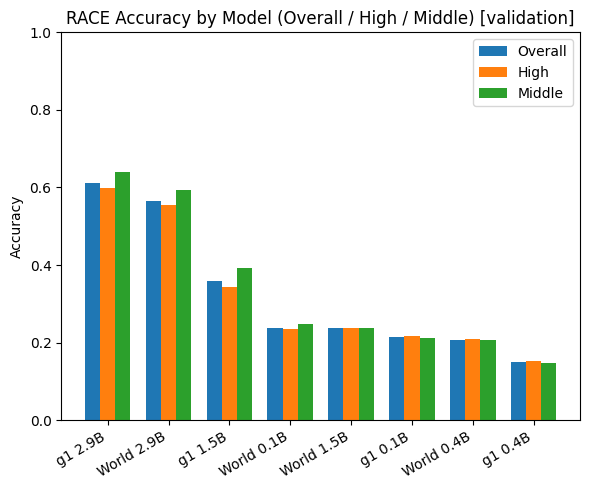

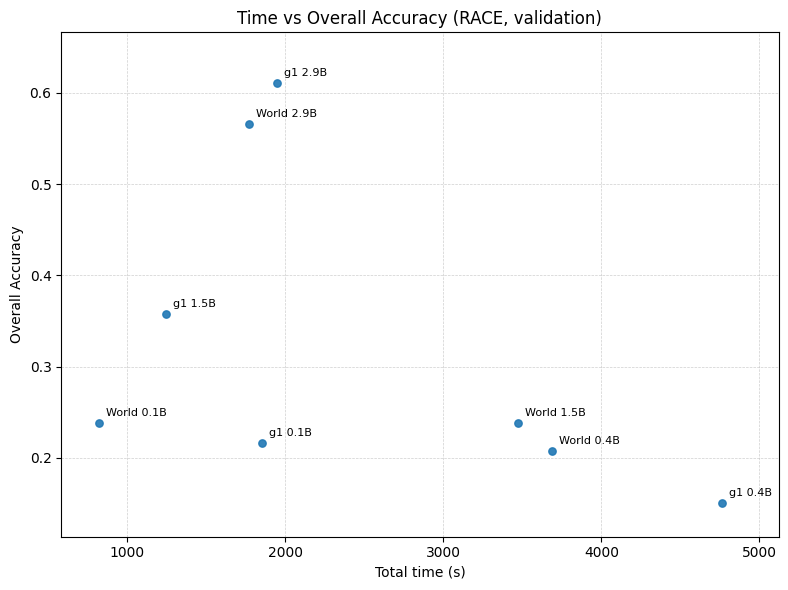

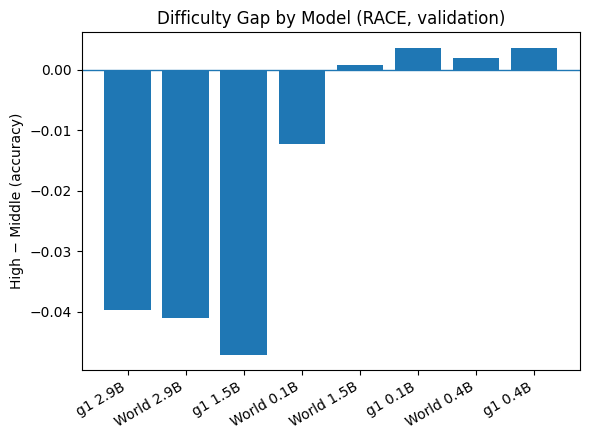

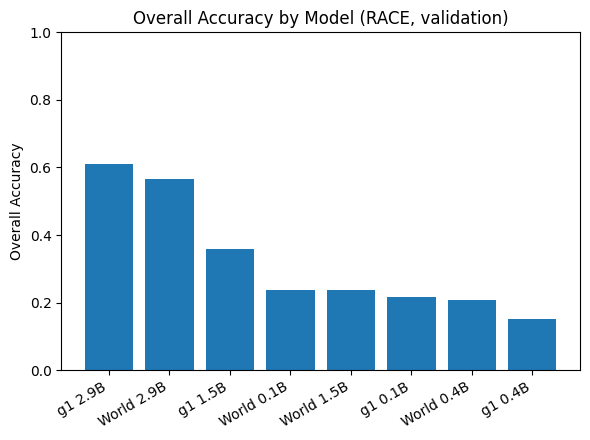

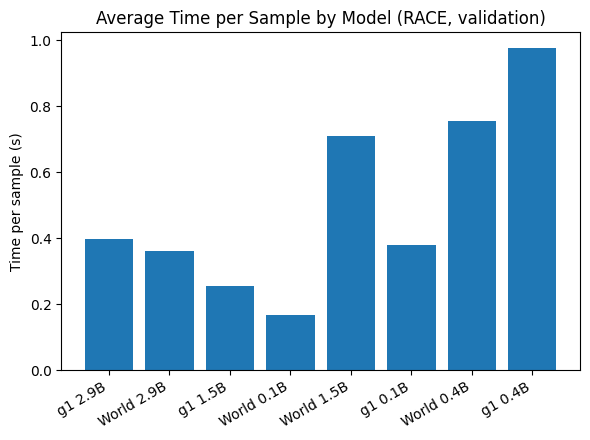

In [48]:
# -*- coding: utf-8 -*-
# Visualize RACE results (matplotlib only, one chart per figure, no custom colors)
# Compatible with:
# 1) Old version:  outputs/RACE_<split)_summary.json
# 2) New aligned: outputs_race_aligned/RACE_<split>_summary_aligned.json

import json
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------------
# Paths and basic configs
# -------------------------------------------------------------------

EVAL_SPLIT = "validation"

# ============= ROOT DIRECTORY ON YOUR "LOCAL" (GOOGLE DRIVE) ==========
# This is the base directory you mentioned as "local"
BASE_DIR = Path("/content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV Dataset Test")

# Choose which version you are plotting:
#   Old version:
#       OUTPUTS_DIR = BASE_DIR / "outputs"
#       SUMMARY_FILENAME = f"RACE_{EVAL_SPLIT}_summary.json"
#   New aligned version (current default):
OUTPUTS_DIR = BASE_DIR / "outputs_race_aligned"
SUMMARY_FILENAME = f"RACE_{EVAL_SPLIT}_summary_aligned.json"
# ======================================================================

JSON_PATH = OUTPUTS_DIR / SUMMARY_FILENAME
FIG_DIR = OUTPUTS_DIR  # save figures alongside the json

# -------------------------------------------------------------------
# IO helpers
# -------------------------------------------------------------------

def load_results(json_path: Path):
    """Load results from the RACE summary json produced by your script."""
    if not json_path.exists():
        raise FileNotFoundError(f"File not found: {json_path}")
    with json_path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, dict):
        raise ValueError("Expected a dict mapping model_name -> metrics dict.")
    return data


def to_rows(results_dict):
    """Convert dict to list of row dicts with safe defaults (compatible with different field names)."""
    rows = []
    for model, metrics in results_dict.items():
        # Compatible with two naming schemes: High vs Hard, Middle vs Normal
        high_acc = metrics.get("High Accuracy", metrics.get("Hard Accuracy", float("nan")))
        middle_acc = metrics.get("Middle Accuracy", metrics.get("Normal Accuracy", float("nan")))

        rows.append({
            "model": str(model),
            "total_time": float(metrics.get("Total time", float("nan"))),
            "overall": float(metrics.get("Overall Accuracy", float("nan"))),
            "high": float(high_acc),
            "middle": float(middle_acc),
            "num_samples": float(metrics.get("Num samples", float("nan"))),
            # Some versions have Num few-shots, some do not
            "num_few_shots": float(metrics.get("Num few-shots", float("nan"))),
        })
    return rows


def sort_rows(rows, key="overall", reverse=True):
    """Sort rows by a metric; NaNs go to the end."""
    valid = [r for r in rows if not math.isnan(r.get(key, float("nan")))]
    invalid = [r for r in rows if math.isnan(r.get(key, float("nan")))]
    valid_sorted = sorted(valid, key=lambda r: r[key], reverse=reverse)
    return valid_sorted + invalid


def ensure_outdir(path: Path):
    """Make sure the directory exists."""
    path.mkdir(parents=True, exist_ok=True)


# -------------------------------------------------------------------
# Plot helpers
# -------------------------------------------------------------------

def grouped_bar_accuracy(rows, outpath: Path):
    """Grouped bar chart: Overall / High / Middle accuracy per model."""
    models = [r["model"] for r in rows]
    overall = [r["overall"] for r in rows]
    high = [r["high"] for r in rows]
    middle = [r["middle"] for r in rows]

    x = range(len(models))
    width = 0.25

    plt.figure(figsize=(max(6, len(models) * 0.75), 5))
    plt.bar([i - width for i in x], overall, width, label="Overall")
    plt.bar(x, high, width, label="High")
    plt.bar([i + width for i in x], middle, width, label="Middle")

    plt.xticks(list(x), models, rotation=30, ha="right")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title(f"RACE Accuracy by Model (Overall / High / Middle) [{EVAL_SPLIT}]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()


def scatter_time_vs_accuracy(rows, outpath: Path, top_k: int = 6):
    """Scatter: Total time (s) vs Overall accuracy.
    - Labels only top-K by accuracy + 4 extremes (min/max time, min/max accuracy).
    """
    xs, ys, labels = [], [], []
    for r in rows:
        if not math.isnan(r["total_time"]) and not math.isnan(r["overall"]):
            xs.append(r["total_time"])
            ys.append(r["overall"])
            labels.append(r["model"])

    if len(xs) == 0:
        raise ValueError("No valid points to plot.")

    plt.figure(figsize=(8, 6))
    plt.scatter(xs, ys, s=28, alpha=0.9)

    xs_np = np.array(xs)
    ys_np = np.array(ys)

    # extreme indices
    idx_min_time = int(np.argmin(xs_np))
    idx_max_time = int(np.argmax(xs_np))
    idx_min_acc = int(np.argmin(ys_np))
    idx_max_acc = int(np.argmax(ys_np))
    extreme_idx = {idx_min_time, idx_max_time, idx_min_acc, idx_max_acc}

    # top-K by accuracy
    k = min(top_k, len(ys_np))
    topk_idx = set(np.argsort(ys_np)[-k:].tolist())

    keep_idx = extreme_idx | topk_idx

    for i in sorted(keep_idx):
        plt.annotate(labels[i], (xs[i], ys[i]),
                     xytext=(5, 5),
                     textcoords="offset points",
                     fontsize=8)

    x_pad = (max(xs) - min(xs)) * 0.06 if max(xs) > min(xs) else 1.0
    y_pad = (max(ys) - min(ys)) * 0.08 if max(ys) > min(ys) else 0.05
    plt.xlim(min(xs) - x_pad, max(xs) + x_pad * 1.5)
    plt.ylim(min(ys) - y_pad, max(ys) + y_pad * 1.5)
    plt.margins(x=0.02, y=0.05)

    plt.xlabel("Total time (s)")
    plt.ylabel("Overall Accuracy")
    plt.title(f"Time vs Overall Accuracy (RACE, {EVAL_SPLIT})")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()


def bar_difficulty_gap(rows, outpath: Path):
    """Bar: (High - Middle) accuracy per model."""
    models = [r["model"] for r in rows]
    gaps = []
    for r in rows:
        h, m = r["high"], r["middle"]
        gaps.append(float("nan") if (math.isnan(h) or math.isnan(m)) else (h - m))

    x = range(len(models))
    plt.figure(figsize=(max(6, len(models) * 0.7), 4.5))
    plt.bar(x, gaps)
    plt.axhline(0, linewidth=1)

    plt.xticks(list(x), models, rotation=30, ha="right")
    plt.ylabel("High − Middle (accuracy)")
    plt.title(f"Difficulty Gap by Model (RACE, {EVAL_SPLIT})")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()


def bar_overall_accuracy(rows, outpath: Path):
    """Simple bar chart of overall accuracy (sorted by overall)."""
    models = [r["model"] for r in rows]
    overall = [r["overall"] for r in rows]

    x = range(len(models))
    plt.figure(figsize=(max(6, len(models) * 0.7), 4.5))
    plt.bar(x, overall)

    plt.xticks(list(x), models, rotation=30, ha="right")
    plt.ylabel("Overall Accuracy")
    plt.ylim(0, 1)
    plt.title(f"Overall Accuracy by Model (RACE, {EVAL_SPLIT})")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()


def bar_time_per_sample(rows, outpath: Path):
    """Bar chart: average time per sample (Total time / Num samples)."""
    models = [r["model"] for r in rows]
    tps = []
    for r in rows:
        tt = r["total_time"]
        n = r["num_samples"]
        if math.isnan(tt) or math.isnan(n) or n <= 0:
            tps.append(float("nan"))
        else:
            tps.append(tt / n)

    x = range(len(models))
    plt.figure(figsize=(max(6, len(models) * 0.7), 4.5))
    plt.bar(x, tps)

    plt.xticks(list(x), models, rotation=30, ha="right")
    plt.ylabel("Time per sample (s)")
    plt.title(f"Average Time per Sample by Model (RACE, {EVAL_SPLIT})")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()


# -------------------------------------------------------------------
# Main
# -------------------------------------------------------------------

def main():
    ensure_outdir(OUTPUTS_DIR)
    results = load_results(JSON_PATH)
    rows = to_rows(results)

    # sort by overall accuracy (descending)
    rows_sorted = sort_rows(rows, key="overall", reverse=True)

    # 01: grouped accuracy (Overall / High / Middle)
    grouped_bar_accuracy(
        rows_sorted,
        FIG_DIR / f"RACE_{EVAL_SPLIT}_01_grouped_accuracy.png"
    )

    # 02: time vs overall accuracy (scatter)
    scatter_time_vs_accuracy(
        rows_sorted,
        FIG_DIR / f"RACE_{EVAL_SPLIT}_02_time_vs_overall.png",
        top_k=len(rows_sorted),
    )

    # 03: difficulty gap (High - Middle)
    bar_difficulty_gap(
        rows_sorted,
        FIG_DIR / f"RACE_{EVAL_SPLIT}_03_high_middle_gap.png"
    )

    # 04: sorted overall accuracy bar chart
    bar_overall_accuracy(
        rows_sorted,
        FIG_DIR / f"RACE_{EVAL_SPLIT}_04_overall_bar.png"
    )

    # 05: average time per sample bar chart
    bar_time_per_sample(
        rows_sorted,
        FIG_DIR / f"RACE_{EVAL_SPLIT}_05_time_per_sample.png"
    )


if __name__ == "__main__":
    main()
